# Dependencies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer

import numpy as np
from sklearn.model_selection import GridSearchCV
import joblib as jb

import warnings as w 
w.filterwarnings('ignore')

In [2]:
data = pd.read_csv('Dataset_B_hotel.csv')
data

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,INN00001,2,0,1,2,Meal Plan 1,0.0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0,Not_Canceled
1,INN00002,2,0,2,3,Not Selected,0.0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1,Not_Canceled
2,INN00003,1,0,2,1,Meal Plan 1,0.0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.00,0,Canceled
3,INN00004,2,0,0,2,Meal Plan 1,0.0,Room_Type 1,211,2018,5,20,Online,0,0,0,100.00,0,Canceled
4,INN00005,2,0,1,1,Not Selected,0.0,Room_Type 1,48,2018,4,11,Online,0,0,0,94.50,0,Canceled
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36270,INN36271,3,0,2,6,Meal Plan 1,0.0,Room_Type 4,85,2018,8,3,Online,0,0,0,167.80,1,Not_Canceled
36271,INN36272,2,0,1,3,Meal Plan 1,0.0,Room_Type 1,228,2018,10,17,Online,0,0,0,90.95,2,Canceled
36272,INN36273,2,0,2,6,Meal Plan 1,0.0,Room_Type 1,148,2018,7,1,Online,0,0,0,98.39,2,Not_Canceled
36273,INN36274,2,0,0,3,Not Selected,0.0,Room_Type 1,63,2018,4,21,Online,0,0,0,94.50,0,Canceled


Atribut seperti Booking_ID dapat didrop karena hanya **berstatus unique identifier**, berlaku juga untuk arrival date yang sudah diwakili dengan lead_time

In [3]:
todrop = ['Booking_ID', 'arrival_date']

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36275 entries, 0 to 36274
Data columns (total 19 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Booking_ID                            36275 non-null  object 
 1   no_of_adults                          36275 non-null  int64  
 2   no_of_children                        36275 non-null  int64  
 3   no_of_weekend_nights                  36275 non-null  int64  
 4   no_of_week_nights                     36275 non-null  int64  
 5   type_of_meal_plan                     35368 non-null  object 
 6   required_car_parking_space            35005 non-null  float64
 7   room_type_reserved                    36275 non-null  object 
 8   lead_time                             36275 non-null  int64  
 9   arrival_year                          36275 non-null  int64  
 10  arrival_month                         36275 non-null  int64  
 11  arrival_date   

In [5]:
# NULL values
na = data.isnull().sum()
na[na > 0]

type_of_meal_plan              907
required_car_parking_space    1270
avg_price_per_room            1632
dtype: int64

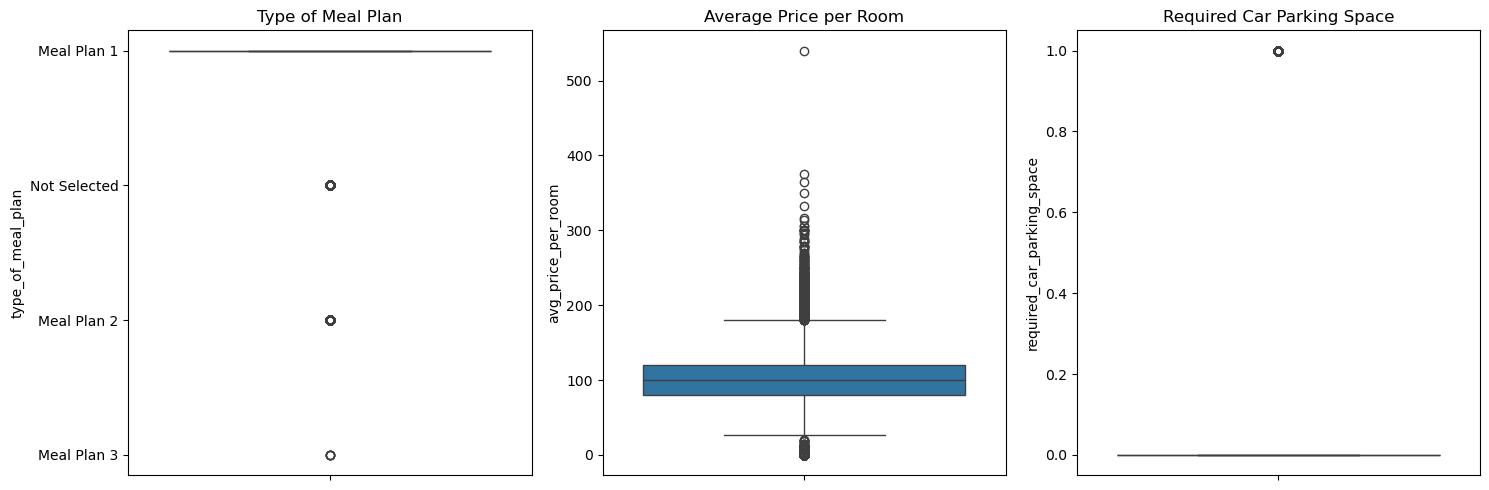

In [6]:
# Buat figure dengan 3 subplot (1 baris, 3 kolom)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot pertama: type_of_meal_plan
sns.boxplot(y=data['type_of_meal_plan'], ax=axes[0])
axes[0].set_title('Type of Meal Plan')

# Plot kedua: avg_price_per_room
sns.boxplot(y=data['avg_price_per_room'], ax=axes[1])
axes[1].set_title('Average Price per Room')

# Plot ketiga: required_car_parking_space
sns.boxplot(y=data['required_car_parking_space'], ax=axes[2])
axes[2].set_title('Required Car Parking Space')

plt.tight_layout()  # Untuk mengatur jarak antar plot
plt.show()

impute method:
meal plan, req parking -> mode  
avg price -> median

# OOP Cases

In [7]:
class DataHandler:
    def __init__(self, path):
        self.path = path
        self.X = None
        self.y = None
        self.label_map = None
        self.data = None
        self.x_train, self.x_test, self.y_train, self.y_test = [None]*4
        self.ts, self.rs = 0.2, 42
        self.encoder = LabelEncoder()
        self.y_raw = None

    def load_data(self):
        self.data = pd.read_csv(self.path)
        self.data = self.data.drop(columns=todrop, axis=1)

    def _encode_target(self, target):
        self.y_raw = target.copy()
        self.y = self.encoder.fit_transform(target)
        self.label_map = dict(zip(self.encoder.classes_,range(len(self.encoder.classes_))))

    def target_split(self):
        target = self.data.columns[len(self.data.columns)-1]
        self.y = self.data[target]
        self.X = self.data.drop(target, axis=1)
        self._encode_target(self.y)

    def split_data(self):
        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=self.ts, random_state=self.rs)

  
    

`DataHandler` berisikan atribut untuk membaca dan mengolah data secara independen melalui load_data, target_encoding (case ini harus diencode), dan target splitting berserta split_data

# Class 2 (Preprocessing)

In [8]:
class Preprocessing:
    def __init__(self, x_train, x_test):
        self.x_train = x_train
        self.x_test = x_test
        self.num_cols, self.cat_cols = None, None
        self.preprocessor = None
        self.feature_names = None
        self.impute = {}

    def _impute_identifier(self):
        # type_of_meal_plan              907 mode
        # required_car_parking_space    1270 median
        # avg_price_per_room            1632 mode
        self.impute = {
            'numeric': {
                'median': ['avg_price_per_room']
            },
            'categoric': {
                'mode' : ['type_of_meal_plan','required_car_parking_space']
            }
        }

    def _apply_impute(self):
            for col in self.impute['numeric']['median']:
                median_val = self.x_train[col].median()
                self.x_train[col].fillna(median_val, inplace=True)
                self.x_test[col].fillna(median_val, inplace=True)
    
            for col in self.impute['categoric']['mode']:
                mode_val = self.x_train[col].mode()[0]  # Take first mode if multiple exist
                self.x_train[col].fillna(mode_val, inplace=True)
                self.x_test[col].fillna(mode_val, inplace=True)
    
    def handle_missing_val(self):
        self._impute_identifier()
        self._apply_impute()

    def _col_identifier(self):
        self.num_cols = self.x_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
        self.cat_cols = self.x_train.select_dtypes(include=['object']).columns.tolist()
        
    def generate_preprocessor(self):
        self._col_identifier()

        ss = StandardScaler() # Numeric transformer
        ohe = OneHotEncoder(handle_unknown='ignore') # Categoric transformer
        self.preprocessors = ColumnTransformer(
            transformers=[
                ('num', ss, self.num_cols),
                ('cat', ohe, self.cat_cols)
            ]
        )

        return self.preprocessors
    
    def apply_preprocessor(self):
        if not self.preprocessors:
            self.generate_preprocessor()

        x_train_preprocessed = self.preprocessors.fit_transform(self.x_train)
        x_test_preprocessed = self.preprocessors.transform(self.x_test)

        num_features = self.preprocessors.named_transformers_['num'].get_feature_names_out(self.num_cols)
        cat_features = self.preprocessors.named_transformers_['cat'].get_feature_names_out(self.cat_cols)

        self.feature_names = np.concatenate([num_features, cat_features])

        self.x_train_processed = pd.DataFrame(
            x_train_preprocessed, 
            columns=self.feature_names,
            index=self.x_train.index
        )

        self.x_test_processed = pd.DataFrame(
            x_test_preprocessed,
            columns=self.feature_names,
            index=self.x_test.index
        )

        return self.x_train_processed, self.x_test_processed
    
    def get_feature_names(self):
        return self.feature_names

    def save_preprocessor(self, fpath):
        import joblib as jb
        jb.dump(self.preprocessor, fpath)

        

`Prepocessing` berisikan prosedur untuk preprocess data agar siap digunakan, melalui proses fillna dengan modul handle_missing_value dan **penggunaan ColumnTransformer** yang berperan untuk melakukan preprocess keseluruhan dengan metode **StandardScaler untuk numerik** dan **OneHotEncoder untuk kategorik**, disertai dengan modul save preprocessor, untuk penggunaan kedepanya

# Class 3 (Model Trainer)

In [9]:
class ModelTrainer:
    def __init__(self, x_train, y_train, x_test, y_test):
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test
        self.y_pred = None
        self.model = {}
        self.best_model = None

    def train_model(self):
        rf = RandomForestClassifier(random_state=42)
        xg = xgb.XGBClassifier(random_state=42)

        rf.fit(self.x_train, self.y_train)
        xg.fit(self.x_train, self.y_train)

        self.model = {
            'RandomForest' : rf,
            'XGBoost' : xg
        }

    def eval_model(self):
        result = {}
        for name,model in self.model.items():
            self.y_pred = model.predict(self.x_test)
            acc = accuracy_score(self.y_test, self.y_pred)
            report = classification_report(self.y_test, self.y_pred)

            result[name] = {
                'accuracy' : acc,
                'report' : report,
                'model' : model
            }

            print(f"\n{name} Performance:\n")
            print(f"Accuracy: {acc:.4f}")
            print("\nClassification Report:\n")
            print(report)
        
        return result
    
    def select_best_model(self, result):
        self.best_model = max(result.items(), key=lambda x: x[1]['accuracy'])
        print(f"\nBest model is {self.best_model[0]} with accuracy {self.best_model[1]['accuracy']:.4f}")

        return self.best_model
    
    # IMPORTANT ASPECT \/\/
    def save_pipeline(self, preprocessor, fname):
        pipeline = {
            'preprocessor': preprocessor.preprocessors,  # For ColumnTransformer
            'best_model': self.best_model[1]['model'],   # best model retrieved
            'feature_names': preprocessor.feature_names, # columns for later use
            'label_encoder': data_used.encoder           # encoder here is LabelEncoder, 
                                                         # because OneHotEncoder is included in ColumnTransformer
        }
        jb.dump(pipeline, fname)

`ModelTrainer` bertugas untuk menjalani prosedur pada Model yang digunakan untuk inference, seperti train_model dengan fitting, lalu tampilan evaluasi dengan metrik akurasi dan Classification Report, berserta perbandingan model yang akan digunakan dan assign menjadi best model, lalu membuat pipeline untuk mencakup segala proses dari kelas 1 hingga kelas model trainer ini

# Class 4 inference 

In [10]:
class ModelInference():
    def __init__(self, pipeline_path):
        try:
            self.pipeline = jb.load(pipeline_path)
            self.preprocessor = self.pipeline['preprocessor']
            self.feature_names = self.pipeline['feature_names']
            self.label_encoder = self.pipeline.get('label_encoder')
        except Exception as e:
            raise ValueError(f"Failed to load pipeline: {str(e)}")
    
    def _val_input(self, data_new):
        if not isinstance(data_new, pd.DataFrame):
            raise TypeError("Input must be a pandas DataFrame")
        
        original_cat_cols = []
        if hasattr(self.preprocessor, 'named_transformers_') and 'cat' in self.preprocessor.named_transformers_:
            original_cat_cols = self.preprocessor.named_transformers_['cat'].feature_names_in_

        missing_features = set(original_cat_cols) - set(data_new.columns)
        if missing_features:
            raise ValueError(f"Missing features: {missing_features}")
        
    def predict(self, data_new):
        self._val_input(data_new)

        preprocessed_data = self.preprocessor.transform(data_new)

        preprocessed_df = pd.DataFrame(
            preprocessed_data,
            columns=self.feature_names
        )



        pred = self.pipeline['best_model'].predict(preprocessed_df)
        pred_proba = self.pipeline['best_model'].predict_proba(preprocessed_df)

        if self.label_encoder:
            pred = self.label_encoder.inverse_transform(pred)

        conf = np.max(pred_proba, axis=1)[0]

        return {
            'prediction': pred[0],
            'probability': pred_proba[0].tolist(),
            'confidence': float(conf),
            'success': True
        }
    

In [11]:
fpath = "Dataset_B_hotel.csv"

data_used = DataHandler(fpath)
data_used.load_data()
data_used.target_split()
data_used.split_data()

In [12]:
data_used.x_train.head()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests
25629,2,1,2,1,Meal Plan 1,0.0,Room_Type 1,26,2017,10,Online,0,0,0,161.00,0
14473,2,1,1,1,Meal Plan 1,0.0,Room_Type 1,98,2018,7,Online,0,0,0,121.50,2
23720,2,0,0,3,Meal Plan 1,0.0,Room_Type 1,433,2018,9,Offline,0,0,0,70.00,0
5843,2,0,2,5,Meal Plan 1,0.0,Room_Type 1,195,2018,8,Offline,0,0,0,72.25,0
18709,1,0,0,2,Meal Plan 1,0.0,Room_Type 1,188,2018,6,Offline,0,0,0,130.00,0


In [13]:
data_used.y_train

array([1, 1, 0, ..., 1, 0, 1])

In [14]:
data_used.label_map

{'Canceled': 0, 'Not_Canceled': 1}

In [15]:
preprocessor = Preprocessing(data_used.x_train, data_used.x_test)
preprocessor.handle_missing_val()
preprocessor.generate_preprocessor()
x_train_processed, x_test_processed = preprocessor.apply_preprocessor()

print("Processsed features:", preprocessor.get_feature_names())

preprocessor.save_preprocessor('preprocessor.joblib')

Processsed features: ['no_of_adults' 'no_of_children' 'no_of_weekend_nights'
 'no_of_week_nights' 'required_car_parking_space' 'lead_time'
 'arrival_year' 'arrival_month' 'repeated_guest'
 'no_of_previous_cancellations' 'no_of_previous_bookings_not_canceled'
 'avg_price_per_room' 'no_of_special_requests'
 'type_of_meal_plan_Meal Plan 1' 'type_of_meal_plan_Meal Plan 2'
 'type_of_meal_plan_Meal Plan 3' 'type_of_meal_plan_Not Selected'
 'room_type_reserved_Room_Type 1' 'room_type_reserved_Room_Type 2'
 'room_type_reserved_Room_Type 3' 'room_type_reserved_Room_Type 4'
 'room_type_reserved_Room_Type 5' 'room_type_reserved_Room_Type 6'
 'room_type_reserved_Room_Type 7' 'market_segment_type_Aviation'
 'market_segment_type_Complementary' 'market_segment_type_Corporate'
 'market_segment_type_Offline' 'market_segment_type_Online']


In [16]:
x_train_processed.head()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,required_car_parking_space,lead_time,arrival_year,arrival_month,repeated_guest,no_of_previous_cancellations,...,room_type_reserved_Room_Type 3,room_type_reserved_Room_Type 4,room_type_reserved_Room_Type 5,room_type_reserved_Room_Type 6,room_type_reserved_Room_Type 7,market_segment_type_Aviation,market_segment_type_Complementary,market_segment_type_Corporate,market_segment_type_Offline,market_segment_type_Online
25629,0.300222,2.204559,1.373324,-0.856920,-0.178901,-0.691565,-2.137519,0.844278,-0.162657,-0.063513,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
14473,0.300222,2.204559,0.221378,-0.856920,-0.178901,0.147033,0.467832,-0.136113,-0.162657,-0.063513,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
23720,0.300222,-0.262235,-0.930567,0.568823,-0.178901,4.048843,0.467832,0.517481,-0.162657,-0.063513,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5843,0.300222,-0.262235,1.373324,1.994567,-0.178901,1.276811,0.467832,0.190684,-0.162657,-0.063513,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
18709,-1.627739,-0.262235,-0.930567,-0.144048,-0.178901,1.195281,0.467832,-0.462910,-0.162657,-0.063513,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [17]:
x_test_processed.head()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,required_car_parking_space,lead_time,arrival_year,arrival_month,repeated_guest,no_of_previous_cancellations,...,room_type_reserved_Room_Type 3,room_type_reserved_Room_Type 4,room_type_reserved_Room_Type 5,room_type_reserved_Room_Type 6,room_type_reserved_Room_Type 7,market_segment_type_Aviation,market_segment_type_Complementary,market_segment_type_Corporate,market_segment_type_Offline,market_segment_type_Online
4968,0.300222,2.204559,0.221378,-1.569792,-0.178901,-0.959450,-2.137519,0.190684,-0.162657,-0.063513,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
34540,0.300222,-0.262235,0.221378,-0.144048,-0.178901,-0.889567,0.467832,-1.770097,-0.162657,-0.063513,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
36108,0.300222,-0.262235,1.373324,-0.144048,-0.178901,-0.714859,0.467832,1.497871,-0.162657,-0.063513,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1553,0.300222,-0.262235,-0.930567,0.568823,-0.178901,-0.726506,0.467832,-0.462910,-0.162657,-0.063513,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
24974,0.300222,2.204559,-0.930567,-0.144048,-0.178901,-0.889567,0.467832,0.517481,-0.162657,-0.063513,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [18]:
model_trainer = ModelTrainer(x_train_processed,
                             data_used.y_train,
                             x_test_processed,
                             data_used.y_test)

model_trainer.train_model()
results = model_trainer.eval_model()

best_model = model_trainer.select_best_model(results)
model_trainer.save_pipeline(preprocessor, 'dataset_B_pipeline.joblib')




RandomForest Performance:

Accuracy: 0.8977

Classification Report:

              precision    recall  f1-score   support

           0       0.87      0.81      0.84      2416
           1       0.91      0.94      0.92      4839

    accuracy                           0.90      7255
   macro avg       0.89      0.88      0.88      7255
weighted avg       0.90      0.90      0.90      7255


XGBoost Performance:

Accuracy: 0.8918

Classification Report:

              precision    recall  f1-score   support

           0       0.87      0.80      0.83      2416
           1       0.90      0.94      0.92      4839

    accuracy                           0.89      7255
   macro avg       0.88      0.87      0.88      7255
weighted avg       0.89      0.89      0.89      7255


Best model is RandomForest with accuracy 0.8977


## Test Cases

Penyediaan beberapa test case untuk dijadikan tolak ukur dari user input terhadap model yang sudah ditrain dan terpilih menjadi best model  

In [19]:
booking_1 = pd.DataFrame([{
    'no_of_adults': 2,
    'no_of_children': 0,
    'no_of_weekend_nights': 1,
    'no_of_week_nights': 2,
    'type_of_meal_plan': 'Meal Plan 1',
    'required_car_parking_space': 0,
    'room_type_reserved': 'Room_Type 1',
    'lead_time': 14,
    'arrival_year':2017,
    'arrival_month': 6,
    'market_segment_type': 'Online',
    'repeated_guest': 0,
    'no_of_previous_cancellations': 0,
    'no_of_previous_bookings_not_canceled': 0,
    'avg_price_per_room': 85.0,
    'no_of_special_requests': 1
}])

inference = ModelInference('dataset_B_pipeline.joblib')
result = inference.predict(booking_1)

print("\nTest Case 1 - Normal Booking:")
print(f"Prediction: {result['prediction']}")
print(f"Confidence: {result['confidence']:.2%}")
print(f"Probabilities: {result['probability']}")


Test Case 1 - Normal Booking:
Prediction: Not_Canceled
Confidence: 59.00%
Probabilities: [0.41, 0.59]


In [20]:
booking_2 = pd.DataFrame([{
    'no_of_adults': 1,
    'no_of_children': 0,
    'no_of_weekend_nights': 2,
    'no_of_week_nights': 5,
    'type_of_meal_plan': 'Meal Plan 1',
    'required_car_parking_space': 0,
    'room_type_reserved': 'Room_Type 4',  
    'lead_time': 120,  # Very long lead time (higher cancellation risk)
    'arrival_year':2017,
    'arrival_month': 7,  # Peak season
    'market_segment_type': 'Online',  # Online bookings have higher cancellation rates
    'repeated_guest': 0,  # Not a loyal customer
    'no_of_previous_cancellations': 3,  # History of cancellations
    'no_of_previous_bookings_not_canceled': 1,
    'avg_price_per_room': 250.0,  # Expensive room
    'no_of_special_requests': 3  # Multiple special requests (could indicate higher expectations)
}])

# Run inference
inference = ModelInference('dataset_B_pipeline.joblib')
result = inference.predict(booking_2)

print("\nTest Case 2 - High-Risk Booking:")
print(f"Prediction: {result['prediction']}")
print(f"Confidence: {result['confidence']:.2%}")
print(f"Probabilities: {result['probability']}")


Test Case 2 - High-Risk Booking:
Prediction: Canceled
Confidence: 50.00%
Probabilities: [0.5, 0.5]
